MANU C

MACHINE LEARNING AND ARTIFICIAL INTELLIGENCE INTERNS at QUANT MASTER TECHNOLOGIES PVT 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Conv2D, MaxPooling2D




In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 97 kB 4.1 MB/s 


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Workout/bitcoin.csv')
df.head(7)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1325318220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1325318280,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Workout/bitcoin.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
df = df.set_index('Timestamp')
df['price'] = (df['High']+ df['Low'])/2
df = df.resample('6H').mean()
df = df.dropna()

In [ ]:
prediction_days = 500
df_train= df['price'][:len(df['price'])-prediction_days].values.reshape(-1,1)
df_test= df['price'][len(df['price'])-prediction_days:].values.reshape(-1,1)

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [ ]:
def create_dataset(dataset, look_back=30):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(scaled_train)
testX, testY = create_dataset(scaled_test)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

def model_builder(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32), return_sequences=True, input_shape= ( trainX.shape[1], trainX.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
    model.add(Dense(30, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
   
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    
    return model
    
tuner = kt.RandomSearch(model_builder, objective="mse", max_trials = 3, executions_per_trial =1,directory = "./")

tuner.search(x=trainX, y=trainY, epochs = 150, batch_size =128, validation_data=(testX, testY), shuffle=False)

Trial 3 Complete [00h 23m 08s]
mse: 0.07578345388174057

Best mse So Far: 0.0005549447960220277
Total elapsed time: 00h 57m 54s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
input_unit: 96
n_layers: 3
lstm_0_units: 256
layer_2_neurons: 320
Dropout_rate: 0.05
dense_activation: sigmoid
lstm_1_units: 32
lstm_2_units: 32
Score: 0.0005549447960220277
Trial summary
Hyperparameters:
input_unit: 448
n_layers: 1
lstm_0_units: 480
layer_2_neurons: 352
Dropout_rate: 0.35000000000000003
dense_activation: relu
Score: 0.07578345388174057
Trial summary
Hyperparameters:
input_unit: 160
n_layers: 4
lstm_0_units: 448
layer_2_neurons: 192
Dropout_rate: 0.15000000000000002
dense_activation: relu
lstm_1_units: 320
lstm_2_units: 352
lstm_3_units: 32
Score: 0.07578345388174057


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
history = best_model.fit(x=trainX, y=trainY, epochs = 150, batch_size =128, validation_data=(testX, testY), shuffle=False, verbose=0)

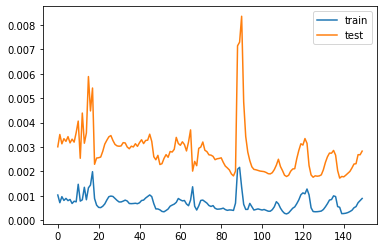

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
predicted_BTC_price = best_model.predict(testX)

In [ ]:
predicted_BTC_price = scaler_test.inverse_transform(predicted_BTC_price.reshape(-1, 1))

In [ ]:
true = scaler_test.inverse_transform(testY.reshape(-1, 1))

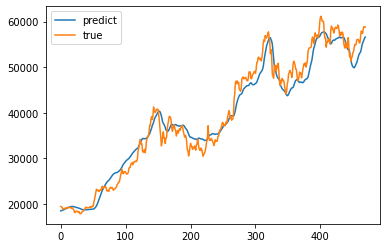

In [ ]:
plt.plot(predicted_BTC_price, label='predict')
plt.plot(true, label='true')
plt.legend()
plt.show()